In [1]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()

# Importing the data

In [2]:
# reading in the data
infile = 'default.csv'
df = spark.read.csv(infile, inferSchema=True, header = True)

In [3]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: inte

## Data Preprocessing

In [4]:
# check the size of the data: 30000 rows and 25 columns
print((df.count(), len(df.columns)))

(30000, 25)


In [5]:
from pyspark.sql import functions as F

# checking for duplicates in our dataset, there are no duplicates since there are in total, 30000 rows
print('rows={}'.format(df.count()))
print('rows={}'.format(df.distinct().count()))

rows=30000
rows=30000


In [6]:
# checking for missing data, there are no missing data
df.agg(*[
    (1 - F.count(c) / F.count('*')).alias(c + '_miss')
    for c in df.columns
]).show()

+-------+--------------+--------+--------------+-------------+--------+----------+----------+----------+----------+----------+----------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------------------------+
|ID_miss|LIMIT_BAL_miss|SEX_miss|EDUCATION_miss|MARRIAGE_miss|AGE_miss|PAY_0_miss|PAY_2_miss|PAY_3_miss|PAY_4_miss|PAY_5_miss|PAY_6_miss|BILL_AMT1_miss|BILL_AMT2_miss|BILL_AMT3_miss|BILL_AMT4_miss|BILL_AMT5_miss|BILL_AMT6_miss|PAY_AMT1_miss|PAY_AMT2_miss|PAY_AMT3_miss|PAY_AMT4_miss|PAY_AMT5_miss|PAY_AMT6_miss|default payment next month_miss|
+-------+--------------+--------+--------------+-------------+--------+----------+----------+----------+----------+----------+----------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-

In [7]:
# checking for outliers

# excluding features with levels and the response variable
cols = [c for c in df.columns if c != 'ID' and c != 'default payment next month' and c!= 'SEX' and c != 'EDUCATION' and c!= 'MARRIAGE'] 
bnds = {} # storing the lower and upper bounds for each feature
for col in cols:
    quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05) #tolerance is 0.05
    IQR = quantiles[1] - quantiles[0]

    bnds[col] = [
     quantiles[0] - 1.5 * IQR,
     quantiles[1] + 1.5 * IQR
    ]
bnds

{'LIMIT_BAL': [-180000.0, 460000.0],
 'AGE': [10.0, 58.0],
 'PAY_0': [-2.5, 1.5],
 'PAY_2': [-2.5, 1.5],
 'PAY_3': [-2.5, 1.5],
 'PAY_4': [-2.5, 1.5],
 'PAY_5': [-2.5, 1.5],
 'PAY_6': [-2.5, 1.5],
 'BILL_AMT1': [-75367.0, 136417.0],
 'BILL_AMT2': [-71850.0, 129038.0],
 'BILL_AMT3': [-68126.5, 122125.5],
 'BILL_AMT4': [-65346.5, 116137.5],
 'BILL_AMT5': [-61606.5, 108317.5],
 'BILL_AMT6': [-60093.0, 104155.0],
 'PAY_AMT1': [-4478.0, 10138.0],
 'PAY_AMT2': [-4118.0, 9530.0],
 'PAY_AMT3': [-4738.5, 9217.5],
 'PAY_AMT4': [-4410.0, 8246.0],
 'PAY_AMT5': [-4437.5, 8262.5],
 'PAY_AMT6': [-4697.5, 8418.5]}

In [8]:
# appending the outlier indicators to the dataframe
outliers = df.select(*['id', 'default payment next month', 'SEX', 'EDUCATION', 'MARRIAGE'] + [
 (
 (df[c] < bnds[c][0]) | (df[c] > bnds[c][1]))
    .alias(c + '_outlier') for c in cols
])

outliers.show(1)

# filtering the rows of the non-categorical features where there are outliers
outliers.filter((outliers[5] == 'true') | (outliers[6] == 'true') |\
               (outliers[7] == 'true') | (outliers[8] == 'true') |\
               (outliers[9] == 'true') | (outliers[10] == 'true') |\
               (outliers[11] == 'true') | (outliers[12] == 'true') |\
               (outliers[13] == 'true') | (outliers[14] == 'true') |\
               (outliers[15] == 'true') | (outliers[16] == 'true') | \
               (outliers[17] == 'true') | (outliers[18] == 'true') |\
               (outliers[19] == 'true') | (outliers[20] == 'true') |\
               (outliers[21] == 'true') | (outliers[22] == 'true') |\
               (outliers[23] == 'true') | (outliers[24] == 'true')).count()


+---+--------------------------+---+---------+--------+-----------------+-----------+-------------+-------------+-------------+-------------+-------------+-------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+
| id|default payment next month|SEX|EDUCATION|MARRIAGE|LIMIT_BAL_outlier|AGE_outlier|PAY_0_outlier|PAY_2_outlier|PAY_3_outlier|PAY_4_outlier|PAY_5_outlier|PAY_6_outlier|BILL_AMT1_outlier|BILL_AMT2_outlier|BILL_AMT3_outlier|BILL_AMT4_outlier|BILL_AMT5_outlier|BILL_AMT6_outlier|PAY_AMT1_outlier|PAY_AMT2_outlier|PAY_AMT3_outlier|PAY_AMT4_outlier|PAY_AMT5_outlier|PAY_AMT6_outlier|
+---+--------------------------+---+---------+--------+-----------------+-----------+-------------+-------------+-------------+-------------+-------------+-------------+-----------------+-----------------+-----------------+-----------------

18052

Since over half of the dataset contains outliers, maybe it is best to not remove any outliers

# Exploratory data analysis

Y: default payment next month (1 = Default, 0 = Not Default)

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education Levels (1 = graduate school; 2 = university; 3 = high school; 4 = others).

In [9]:
# define two functions for quick plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

def pie1(data, label, title):
    '''A function to create a pie chart'''
    mpl.rcParams['figure.dpi']= 120
    plt.figure(figsize=(2.5,2.5))
    plt.pie(data, labels = label, autopct = '%.2f%%')
    plt.title(title, fontsize=10)
    plt.show()
    
def pie2(data1, label1, title1, data2, label2, title2):
    '''A function to create two pie charts in a row'''
    mpl.rcParams['figure.dpi']= 100
    plt.figure(figsize=(2.5,2.5))
    fig, axs = plt.subplots(1,2)
    axs[0].pie(data1, labels = label1, autopct = '%.2f%%')
    axs[0].set_title(title1)
    axs[1].pie(data2, labels = label2, autopct = '%.2f%%')
    axs[1].set_title(title2)
    plt.tight_layout()


In [10]:
# Create subsets

########## Not Default ##########
default_no = df.filter(df['default payment next month'] == 0)

# by gender
default_no_male = default_no.filter(default_no['SEX'] == 1)
default_no_female = default_no.filter(default_no['SEX'] == 2)

# by education level
default_no_grad = default_no.filter(default_no['EDUCATION'] == 1)
default_no_uni = default_no.filter(default_no['EDUCATION'] == 2)
default_no_high = default_no.filter(default_no['EDUCATION'] == 3)
default_no_other = default_no.filter(default_no['EDUCATION'] == 4)

########## Default ##########
default_yes = df.filter(df['default payment next month'] == 1)

# by gender
default_yes_male = default_yes.filter(default_yes['SEX'] == 1)
default_yes_female = default_yes.filter(default_yes['SEX'] == 2)

# by education level
default_yes_grad = default_yes.filter(default_yes['EDUCATION'] == 1)
default_yes_uni = default_yes.filter(default_yes['EDUCATION'] == 2)
default_yes_high = default_yes.filter(default_yes['EDUCATION'] == 3)
default_yes_other = default_yes.filter(default_yes['EDUCATION'] == 4)

## Distribution of Response Variable

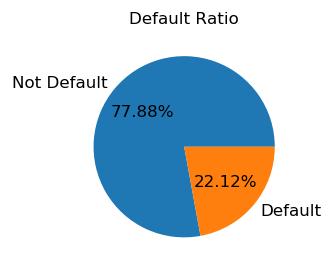

In [11]:
# distribution of default/no default, for all clients
default = [default_no.count(),default_yes.count()]
default_label = ["Not Default","Default"]
pie1(default, default_label, "Default Ratio")

## Client Gender Distribution

<Figure size 250x250 with 0 Axes>

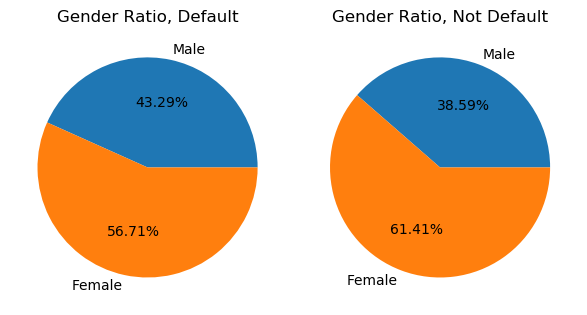

In [12]:
# people who default next month, by gender
default_yes_gender = [default_yes_male.count(), default_yes_female.count()]
gender_label = ["Male","Female"]

# people who don't default next month, by gender
default_no_gender = [default_no_male.count(), default_no_female.count()]
gender_label = ["Male","Female"]

# pie charts
pie2(default_yes_gender, gender_label, "Gender Ratio, Default",
     default_no_gender, gender_label, "Gender Ratio, Not Default")

## Male and Female Default Ratios

<Figure size 250x250 with 0 Axes>

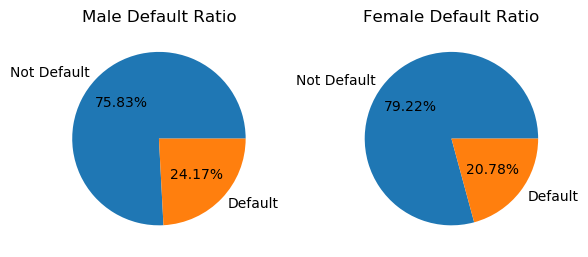

In [13]:
# male default ratio
male_default = [default_no_male.count(), default_yes_male.count()]
default_label = ["Not Default","Default"]

# female default rate
female_default = [default_no_female.count(), default_yes_female.count()]
default_label = ["Not Default","Default"]

# pie charts
pie2(male_default, default_label, "Male Default Ratio",
    female_default, default_label, "Female Default Ratio")

## Client Education Levels

<Figure size 250x250 with 0 Axes>

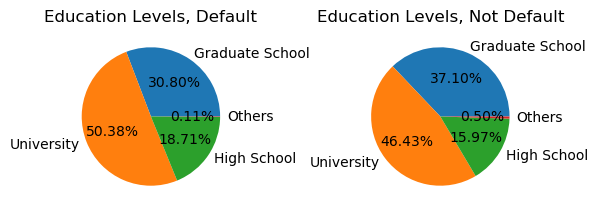

In [14]:
# people who default next month, by education level
default_yes_education = [default_yes_grad.count(), default_yes_uni.count(),
                        default_yes_high.count(), default_yes_other.count()]
education_label = ["Graduate School", "University","High School","Others"]

# people who don't default next month, by education level
default_no_education = [default_no_grad.count(), default_no_uni.count(),
                        default_no_high.count(), default_no_other.count()]
education_label = ["Graduate School", "University","High School","Others"]

# pie charts
pie2(default_yes_education, education_label, "Education Levels, Default",
    default_no_education, education_label, "Education Levels, Not Default")

## Education Levels and Type of Default

<Figure size 600x600 with 0 Axes>

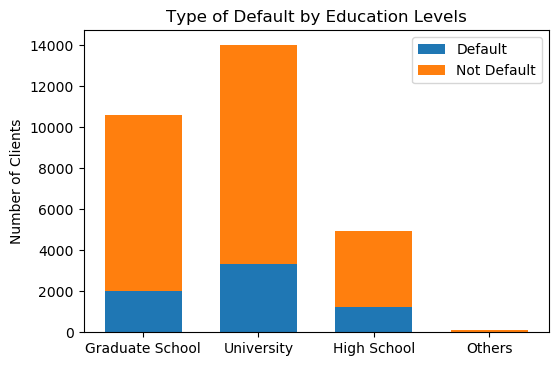

In [15]:
# type of default, by education levels
education_label = ["Graduate School", "University","High School","Others"]
width = 0.666

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.bar(education_label, default_yes_education, width, label='Default')
ax.bar(education_label, default_no_education, width, label='Not Default', bottom=default_yes_education)
ax.set_ylabel('Number of Clients')
ax.set_title('Type of Default by Education Levels')
ax.legend()
plt.show()


## Limit Balance and Type of Default

In [16]:
import pandas as pd
# Not default group
ct_no = default_no.groupby('LIMIT_BAL').count()
ct_no.sort('LIMIT_BAL').show()

+---------+-----+
|LIMIT_BAL|count|
+---------+-----+
|    10000|  296|
|    16000|    2|
|    20000| 1278|
|    30000| 1042|
|    40000|  138|
|    50000| 2480|
|    60000|  592|
|    70000|  521|
|    80000| 1204|
|    90000|  485|
|   100000|  776|
|   110000|  456|
|   120000|  547|
|   130000|  572|
|   140000|  579|
|   150000|  923|
|   160000|  557|
|   170000|  454|
|   180000|  819|
|   190000|  180|
+---------+-----+
only showing top 20 rows



In [17]:
# Default group
ct_yes = default_yes.groupby('LIMIT_BAL').count()
ct_yes.sort('LIMIT_BAL').show()

+---------+-----+
|LIMIT_BAL|count|
+---------+-----+
|    10000|  197|
|    20000|  698|
|    30000|  568|
|    40000|   92|
|    50000|  885|
|    60000|  233|
|    70000|  210|
|    80000|  363|
|    90000|  166|
|   100000|  272|
|   110000|  132|
|   120000|  179|
|   130000|  157|
|   140000|  170|
|   150000|  187|
|   160000|  137|
|   170000|   78|
|   180000|  176|
|   190000|   49|
|   200000|  270|
+---------+-----+
only showing top 20 rows



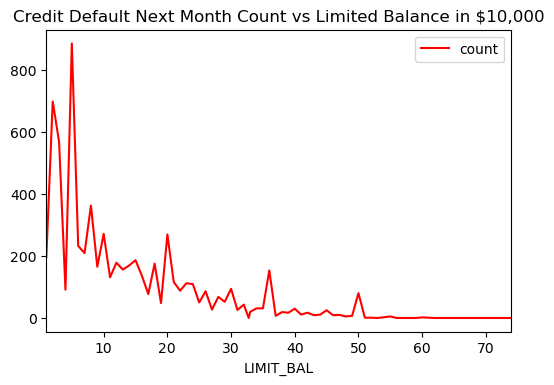

In [18]:
# plot for default group
ct_yes_pd=ct_yes.sort('LIMIT_BAL').toPandas()
ct_yes_pd['LIMIT_BAL']=ct_yes_pd['LIMIT_BAL']/10000
ct_yes_pd['LIMIT_BAL'].round()

ct_yes_pd.plot(x='LIMIT_BAL',y='count',color='red',title='Credit Default Next Month Count vs Limited Balance in $10,000')

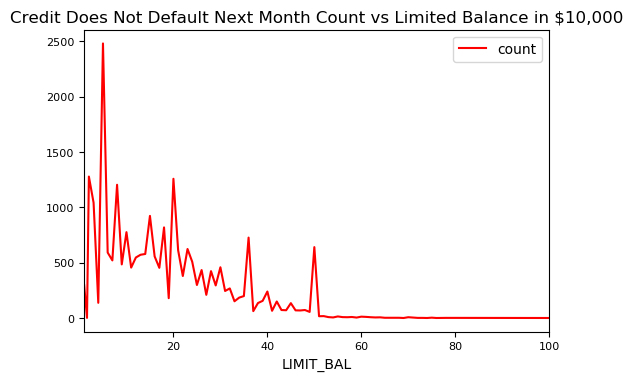

In [19]:
# plot for not default group
ct_no_pd=ct_no.sort('LIMIT_BAL').toPandas()
ct_no_pd['LIMIT_BAL']=ct_no_pd['LIMIT_BAL']/10000
ct_no_pd['LIMIT_BAL'].round()

ct_no_pd.plot(x='LIMIT_BAL',y='count',color='red',fontsize=8,title='Credit Does Not Default Next Month Count vs Limited Balance in $10,000')

# Models and Results

In [20]:
# rename response variable as "label" for easier using
df2 = df.withColumnRenamed("default payment next month", "label")

## Data Splitting

In [21]:
#Split data into train set (70%), test set (30%) using seed=314
training, test = df2.randomSplit([0.7, 0.3], seed=314)

#Count records in datasets
train_count = training.count()
test_count = test.count()
raw_count = df2.count()
records_count = spark.createDataFrame([
    ('Training set', train_count),
    ('Test set', test_count),
    ('Raw data', raw_count),
], ["Datasets", "Count"])

records_count.show()

+------------+-----+
|    Datasets|Count|
+------------+-----+
|Training set|20925|
|    Test set| 9075|
|    Raw data|30000|
+------------+-----+



## Data Balancing

In [22]:
# Since the data is imbalanced, we balance the data using oversampling method. Do this on train set only. 
from pyspark.sql.functions import col, explode, array, lit

major_train = training.filter(col('label') == 0)
minor_train = training.filter(col('label') == 1)
ratio = int(major_train.count()/minor_train.count())
ratio_range = range(ratio)

# Oversample minority class by dulicating the observations in minority class
oversampled_train = minor_train.withColumn("dummy", explode(array([lit(x) for x in ratio_range]))).drop('dummy')

# combine the majority class with oversampled minority class
final_train = major_train.unionAll(oversampled_train)

In [23]:
#check the distribution of the response variable for training set (before oversampling)
train0 = training.filter(training['label'] == 0).count()
train1 = training.filter(training['label'] == 1).count()
train_ls = [train0,train1]
train_lablel = ["default = 0", "default = 1"]
training.groupBy('label').count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1| 4640|
|    0|16285|
+-----+-----+



In [24]:
#check the distribution of the response variable for training set (after oversampling)
final_train0 = final_train.filter(final_train['label'] == 0).count()
final_train1 = final_train.filter(final_train['label'] == 1).count()
finalTrain_ls = [final_train0,final_train1]
finalTrain_label = ["default = 0", "default = 1"]
final_train.groupBy('label').count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1|13920|
|    0|16285|
+-----+-----+



## Benchmark Model (Simple logistic Regression)

In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Build model using pipline

# assembling the features together into one vector (using only 3 features)
assembler_bm = VectorAssembler(inputCols = ['LIMIT_BAL','SEX','AGE',], outputCol="features")

# Create an Logistic Regression model.
bm = LogisticRegression(labelCol= "label", featuresCol="features", maxIter=10, regParam=0.01)

pipeline_bm = Pipeline(stages=[assembler_bm, bm])

# Fit the pipeline
bm_model = pipeline_bm.fit(final_train)

# Make prediction
prediction_bm = bm_model.transform(test)

## Model Evaluation for Benchmark Model

In [26]:
#confusion matrix
from pyspark.mllib.evaluation import MulticlassMetrics

labelsAndPreds_bm = prediction_bm["label", "prediction"].rdd
label_pred_bm = labelsAndPreds_bm.map(lambda p: (float(p.label), float(p.prediction)))
matrix_bm = MulticlassMetrics(label_pred_bm)

print("Confusion Matrix:\n{}".format(matrix_bm.confusionMatrix().toArray()))

Confusion Matrix:
[[4739.  959.]
 [2340. 1037.]]


In [27]:
# calculate accuracy, precision, recall, and F1-score
TP_bm = prediction_bm.filter('prediction = 1 AND label = prediction').count()
TN_bm = prediction_bm.filter('prediction = 0 AND label = prediction').count()
FP_bm = prediction_bm.filter('prediction = 1 AND label <> prediction').count()
FN_bm = prediction_bm.filter('prediction = 0 AND label <> prediction').count()

accuracy_bm = (TN_bm + TP_bm) / (TN_bm + TP_bm + FN_bm + FP_bm)
precision_bm = TP_bm / (TP_bm + FP_bm)
recall_bm = TP_bm / (TP_bm+ FN_bm)
F_bm =  2 * ((precision_bm*recall_bm) / (precision_bm + recall_bm))

In [28]:
print("accuracy: %.4F" % accuracy_bm)
print("precision: %.4F" % precision_bm)
print("recall: %.4F" % recall_bm)
print("F1 score: %.4F" % F_bm)

accuracy: 0.6365
precision: 0.3071
recall: 0.5195
F1 score: 0.3860


In [29]:
# Calculate AUC
eval_bm = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_bm = eval_bm.evaluate(prediction_bm, {eval_bm.metricName: "areaUnderROC"})
print("AUC: %.4F" % auc_bm)

AUC: 0.6229


## Logistic Regression with Cross-Validation

In [30]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler

# Build model using pipeline

# assembling the features together into one vector (removing ID which is not an important variable)
assembler_lr = VectorAssembler(inputCols = ['LIMIT_BAL','SEX',
                       'EDUCATION','MARRIAGE','AGE',
                       'PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6',
                       'BILL_AMT1','BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                       'PAY_AMT1','PAY_AMT2','PAY_AMT3',
                       'PAY_AMT4','PAY_AMT5','PAY_AMT6'], outputCol="unscaled_features")

# Scale features
scaler_lr = StandardScaler(inputCol="unscaled_features", outputCol="scaledFeatures")

# Create an Logistic Regression model.
lr = LogisticRegression(labelCol= "label", featuresCol="scaledFeatures")

pipeline_lr = Pipeline(stages=[assembler_lr, scaler_lr, lr])

# Set up the parameter grid
lr_paramGrid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter,[10, 100, 1000])\
    .addGrid(lr.regParam,[0.1, 0.5, 1.0, 2.0]) \
    .build()

# Create 10-fold CrossValidator
lr_cv = CrossValidator(estimator = pipeline_lr,
                      estimatorParamMaps = lr_paramGrid,
                      evaluator = BinaryClassificationEvaluator(),
                      numFolds = 10,
                      seed = 314)

In [31]:
# Run cross-validation, and choose the best set of parameters.
cv_lrModel = lr_cv.fit(final_train)

In [32]:
# select the best model found by cv
lr_best = cv_lrModel.bestModel

#Make prediction on test set
prediction_lr = lr_best.transform(test)

## Model Evaluation for Logistic Regression

In [33]:
#confusion matrix

labelsAndPreds_lr = prediction_lr["label", "prediction"].rdd
label_pred_lr = labelsAndPreds_lr.map(lambda p: (float(p.label), float(p.prediction)))
matrix_lr = MulticlassMetrics(label_pred_lr)

print("Confusion Matrix:\n{}".format(matrix_lr.confusionMatrix().toArray()))

Confusion Matrix:
[[5928.  920.]
 [1151. 1076.]]


In [34]:
# calculate accuracy, precision, recall, and F1-score
TP_lr = prediction_lr.filter('prediction = 1 AND label = prediction').count()
TN_lr = prediction_lr.filter('prediction = 0 AND label = prediction').count()
FP_lr = prediction_lr.filter('prediction = 1 AND label <> prediction').count()
FN_lr = prediction_lr.filter('prediction = 0 AND label <> prediction').count()

accuracy_lr = (TN_lr + TP_lr) / (TN_lr + TP_lr + FN_lr + FP_lr)
precision_lr = TP_lr / (TP_lr + FP_lr)
recall_lr = TP_lr / (TP_lr + FN_lr)
F_lr =  2 * ((precision_lr*recall_lr) / (precision_lr + recall_lr))

In [35]:
print("accuracy: %.4F" % accuracy_lr)
print("precision: %.4F" % precision_lr)
print("recall: %.4F" % recall_lr)
print("F1 score: %.4F" % F_lr)

accuracy: 0.7718
precision: 0.4832
recall: 0.5391
F1 score: 0.5096


In [36]:
# Calculate AUC
eval_lr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_lr = eval_lr.evaluate(prediction_lr, {eval_lr.metricName: "areaUnderROC"})
print("AUC: %.4F" % auc_lr)

AUC: 0.7254


## Decision Trees

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

In [38]:
assembler_dt = VectorAssembler(inputCols=['LIMIT_BAL','SEX',
                       'EDUCATION','MARRIAGE','AGE',
                       'PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6',
                       'BILL_AMT1','BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                       'PAY_AMT1','PAY_AMT2','PAY_AMT3',
                       'PAY_AMT4','PAY_AMT5','PAY_AMT6'], outputCol="features")

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_dt = Pipeline(stages=[assembler_dt,dt])

In [39]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# ParamGrid for cross validation
paramGrid_dt = ParamGridBuilder()\
             .addGrid(dt.maxDepth, [2, 5, 10])\
             .addGrid(dt.maxBins, [5, 10, 20])\
             .build()
            
# use pipeline as an estimator, 10-fold cross validation, seed 314
crossVal_dt = CrossValidator(estimator = pipeline_dt,
                          estimatorParamMaps = paramGrid_dt,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 10,
                          seed = 314)

In [40]:
# Run cross-validation to choose the best set of parameters.
cv_model_dt = crossVal_dt.fit(final_train)

In [41]:
# select the best model found by cv
dt_best = cv_model_dt.bestModel

# make predictions
prediction_dt = dt_best.transform(test)

## Model Evaluation for Decision Tree

In [42]:
# confusion matrix
label_pred_dt = prediction_dt["label", "prediction"].rdd.map(lambda p: (float(p.prediction), float(p.label)))
matrix_dt = MulticlassMetrics(label_pred_dt)

confusionMatrix = matrix_dt.confusionMatrix().toArray()
print("Confusion Matrix:\n{}".format(confusionMatrix))

Confusion Matrix:
[[5757. 1322.]
 [ 800. 1196.]]


In [43]:
# accuracy, precision, recall, and F1-score
TP_dt = prediction_dt.filter('prediction = 1 AND label = prediction').count()
TN_dt = prediction_dt.filter('prediction = 0 AND label = prediction').count()
FP_dt = prediction_dt.filter('prediction = 1 AND label <> prediction').count()
FN_dt = prediction_dt.filter('prediction = 0 AND label <> prediction').count()

accuracy_dt = (TN_dt + TP_dt) / (TN_dt + TP_dt + FN_dt + FP_dt)
precision_dt = TP_dt / (TP_dt + FP_dt)
recall_dt = TP_dt / (TP_dt+ FN_dt)
F1_dt =  2 * ((precision_dt*recall_dt) / (precision_dt + recall_dt))

print("accuracy: %.4F" % accuracy_dt)
print("precision: %.4F" % precision_dt)
print("recall: %.4F" % recall_dt)
print("F1 score: %.4F" % F1_dt)

accuracy: 0.7662
precision: 0.4750
recall: 0.5992
F1 score: 0.5299


In [44]:
# Area Under ROC
eval_dt = BinaryClassificationEvaluator()
auc_dt = eval_dt.evaluate(prediction_dt, {eval_dt.metricName: "areaUnderROC"})
print("Area Under ROC: %.4F" % auc_dt)

Area Under ROC: 0.6801


## Random Forest

In [45]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build model using pipline

# assembling the features together into one vector (removing ID which is not an important variable)
assembler_rf = VectorAssembler(inputCols = ['LIMIT_BAL','SEX',
                       'EDUCATION','MARRIAGE','AGE',
                       'PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6',
                       'BILL_AMT1','BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                       'PAY_AMT1','PAY_AMT2','PAY_AMT3',
                       'PAY_AMT4','PAY_AMT5','PAY_AMT6'], outputCol="features")

# Create an RandomForest model.
rf = RandomForestClassifier(labelCol= "label", featuresCol="features")

pipeline_rf = Pipeline(stages=[assembler_rf, rf])

# Set up the parameter grid
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.numTrees, [100, 300])
               .addGrid(rf.maxDepth, [2, 5])
               .addGrid(rf.maxBins, [5, 10])
               .build())

# Create 10-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline_rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = BinaryClassificationEvaluator(),
                      numFolds = 10,
                      seed = 314)


In [46]:
# Run cross-validation to choose the best set of parameters.
cv_rfModel = rfcv.fit(final_train)

In [47]:
# select the best model found by cv
rf_best = cv_rfModel.bestModel

#Make prediction on test set
prediction_rf = rf_best.transform(test)

## Model Evaluation for Random Forest

In [48]:
#confusion matrix

labelsAndPreds_rf = prediction_rf["label", "prediction"].rdd
label_pred_rf = labelsAndPreds_rf.map(lambda p: (float(p.label), float(p.prediction)))
matrix_rf = MulticlassMetrics(label_pred_rf)

print("Confusion Matrix:\n{}".format(matrix_rf.confusionMatrix().toArray()))

Confusion Matrix:
[[6095.  878.]
 [ 984. 1118.]]


In [49]:
# calculate accuracy, precision, recall, and F1-score
TP_rf = prediction_rf.filter('prediction = 1 AND label = prediction').count()
TN_rf = prediction_rf.filter('prediction = 0 AND label = prediction').count()
FP_rf = prediction_rf.filter('prediction = 1 AND label <> prediction').count()
FN_rf = prediction_rf.filter('prediction = 0 AND label <> prediction').count()

accuracy_rf = (TN_rf + TP_rf) / (TN_rf + TP_rf + FN_rf + FP_rf)
precision_rf = TP_rf / (TP_rf + FP_rf)
recall_rf = TP_rf / (TP_rf+ FN_rf)
F_rf =  2 * ((precision_rf*recall_rf) / (precision_rf + recall_rf))

In [50]:
print("accuracy: %.4F" % accuracy_rf)
print("precision: %.4F" % precision_rf)
print("recall: %.4F" % recall_rf)
print("F1 score: %.4F" % F_rf)

accuracy: 0.7948
precision: 0.5319
recall: 0.5601
F1 score: 0.5456


In [51]:
# Calculate AUC
eval_rf = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_rf = eval_rf.evaluate(prediction_rf, {eval_rf.metricName: "areaUnderROC"})
print("AUC: %.4F" % auc_rf)

AUC: 0.7749


## Support Vector Machine

In [52]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import StandardScaler

#Build model using pipeline

# assembling the features together into one vector (removing ID which is not an important variable)
assembler_svm = VectorAssembler(inputCols = ['LIMIT_BAL','SEX',
                       'EDUCATION','MARRIAGE','AGE',
                       'PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6',
                       'BILL_AMT1','BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                       'PAY_AMT1','PAY_AMT2','PAY_AMT3',
                       'PAY_AMT4','PAY_AMT5','PAY_AMT6'], outputCol="unscaled_features")

# Scale features
scaler_svm = StandardScaler(inputCol="unscaled_features", outputCol="scaledFeatures")

# Create an svm model.
svm = LinearSVC(labelCol= "label", featuresCol="scaledFeatures")

pipeline_svm = Pipeline(stages=[assembler_svm, scaler_svm, svm])

# Set up the parameter grid
svm_paramGrid = (ParamGridBuilder()
               .addGrid(svm.maxIter, [5, 10, 20])
               .addGrid(svm.regParam, [0.1, 0.05, 0.01])
               .build())

# Create 10-fold CrossValidator
svm_cv = CrossValidator(estimator = pipeline_svm,
                      estimatorParamMaps = svm_paramGrid,
                      evaluator = BinaryClassificationEvaluator(),
                      numFolds = 10,
                      seed = 314)


In [53]:
# Run cross-validation, and choose the best set of parameters.
cv_svmModel = svm_cv.fit(final_train)

In [54]:
# select the best model found by cv
svm_best = cv_svmModel.bestModel

#Make prediction on test set
prediction_svm = svm_best.transform(test)

## Model Evaluation for Support Vector Machine

In [55]:
#confusion matrix

labelsAndPreds_svm = prediction_svm["label", "prediction"].rdd
label_pred_svm = labelsAndPreds_svm.map(lambda p: (float(p.label), float(p.prediction)))
matrix_svm = MulticlassMetrics(label_pred_svm)

print("Confusion Matrix:\n{}".format(matrix_svm.confusionMatrix().toArray()))

Confusion Matrix:
[[6353. 1030.]
 [ 726.  966.]]


In [56]:
# calculate accuracy, precision, recall, and F1-score
TP_svm = prediction_svm.filter('prediction = 1 AND label = prediction').count()
TN_svm = prediction_svm.filter('prediction = 0 AND label = prediction').count()
FP_svm = prediction_svm.filter('prediction = 1 AND label <> prediction').count()
FN_svm = prediction_svm.filter('prediction = 0 AND label <> prediction').count()

accuracy_svm = (TN_svm + TP_svm) / (TN_svm + TP_svm + FN_svm + FP_svm)
precision_svm = TP_svm / (TP_svm + FP_svm)
recall_svm = TP_svm / (TP_svm + FN_svm)
F_svm =  2 * ((precision_svm*recall_svm) / (precision_svm + recall_svm))

In [57]:
print("accuracy: %.4F" % accuracy_svm)
print("precision: %.4F" % precision_svm)
print("recall: %.4F" % recall_svm)
print("F1 score: %.4F" % F_svm)

accuracy: 0.8065
precision: 0.5709
recall: 0.4840
F1 score: 0.5239


In [58]:
# Calculate AUC
eval_svm = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_svm = eval_svm.evaluate(prediction_svm, {eval_svm.metricName: "areaUnderROC"})
print("AUC: %.4F" % auc_svm)

AUC: 0.7309


# Sensitivity Analysis

## Sensitivity Analysis for Benchmark Model

In [59]:
# Change regParam to 0.1 and 0.001
bm1 = LogisticRegression(labelCol= "label", featuresCol="features", maxIter=10, regParam=0.001)
bm2 = LogisticRegression(labelCol= "label", featuresCol="features", maxIter=10, regParam=0.1)

pipeline_bm1 = Pipeline(stages=[assembler_bm, bm1])
pipeline_bm2 = Pipeline(stages=[assembler_bm, bm2])

# Fit the pipeline
bm_model1 = pipeline_bm1.fit(final_train)
bm_model2 = pipeline_bm2.fit(final_train)

# Make prediction
prediction_bm1 = bm_model1.transform(test)
prediction_bm2 = bm_model2.transform(test)

# Calculate new F1 score
TP_bm1 = prediction_bm1.filter('prediction = 1 AND label = prediction').count()
FP_bm1 = prediction_bm1.filter('prediction = 1 AND label <> prediction').count()
FN_bm1 = prediction_bm1.filter('prediction = 0 AND label <> prediction').count()

TP_bm2 = prediction_bm2.filter('prediction = 1 AND label = prediction').count()
FP_bm2 = prediction_bm2.filter('prediction = 1 AND label <> prediction').count()
FN_bm2 = prediction_bm2.filter('prediction = 0 AND label <> prediction').count()

precision_bm1 = TP_bm1 / (TP_bm1 + FP_bm1)
recall_bm1 = TP_bm1 / (TP_bm1 + FN_bm1)
F_bm1 =  2 * ((precision_bm1*recall_bm1) / (precision_bm1 + recall_bm1))

precision_bm2 = TP_bm2 / (TP_bm2 + FP_bm2)
recall_bm2 = TP_bm2 / (TP_bm2 + FN_bm2)
F_bm2 =  2 * ((precision_bm2*recall_bm2) / (precision_bm2 + recall_bm2))

print("F1 score when regParam=0.001: %.4F" % F_bm1)
print("F1 score when regParam=0.01: %.4F" % F_bm)
print("F1 score when regParam=0.1: %.4F" % F_bm2)

F1 score when regParam=0.001: 0.3864
F1 score when regParam=0.01: 0.3860
F1 score when regParam=0.1: 0.3606


## Sensitivity Analysis for Logistic Regression

In [60]:
# Extract best model hyperparameters from the CrossValidator model
print('Best elasticNetParam is: %s, best fitIntercept is: %s, best maxIter is: %s, best regParam is: %s' % 
      (lr_best.stages[-1]._java_obj.getElasticNetParam(),
       lr_best.stages[-1]._java_obj.getFitIntercept(),
       lr_best.stages[-1]._java_obj.getMaxIter(),
       lr_best.stages[-1]._java_obj.getRegParam()))

Best elasticNetParam is: 0.0, best fitIntercept is: True, best maxIter is: 100, best regParam is: 0.1


In [63]:
# Change regParam to 0.01 and 0.001
lr1 = LogisticRegression(labelCol= "label", featuresCol="scaledFeatures", elasticNetParam=0, fitIntercept=True, maxIter=1000, regParam=0.001)
lr2 = LogisticRegression(labelCol= "label", featuresCol="scaledFeatures", elasticNetParam=0, fitIntercept=True, maxIter=1000, regParam=0.01)

pipeline_lr1 = Pipeline(stages=[assembler_lr, scaler_lr, lr1])
pipeline_lr2 = Pipeline(stages=[assembler_lr, scaler_lr, lr2])

# Fit the pipeline
lr_model1 = pipeline_lr1.fit(final_train)
lr_model2 = pipeline_lr2.fit(final_train)

# Make prediction
prediction_lr1 = lr_model1.transform(test)
prediction_lr2 = lr_model2.transform(test)

# Calculate new F1 score
TP_lr1 = prediction_lr1.filter('prediction = 1 AND label = prediction').count()
FP_lr1 = prediction_lr1.filter('prediction = 1 AND label <> prediction').count()
FN_lr1 = prediction_lr1.filter('prediction = 0 AND label <> prediction').count()

TP_lr2 = prediction_lr2.filter('prediction = 1 AND label = prediction').count()
FP_lr2 = prediction_lr2.filter('prediction = 1 AND label <> prediction').count()
FN_lr2 = prediction_lr2.filter('prediction = 0 AND label <> prediction').count()

precision_lr1 = TP_lr1 / (TP_lr1 + FP_lr1)
recall_lr1 = TP_lr1 / (TP_lr1 + FN_lr1)
F_lr1 =  2 * ((precision_lr1*recall_lr1) / (precision_lr1 + recall_lr1))

precision_lr2 = TP_lr2 / (TP_lr2 + FP_lr2)
recall_lr2 = TP_lr2 / (TP_lr2 + FN_lr2)
F_lr2 =  2 * ((precision_lr2*recall_lr2) / (precision_lr2 + recall_lr2))

print("F1 score when regParam=0.001: %.4F" % F_lr1)
print("F1 score when regParam=0.01: %.4F" % F_lr1)
print("F1 score when regParam=0.1: %.4F" % F_lr)

F1 score when regParam=0.001: 0.5086
F1 score when regParam=0.01: 0.5086
F1 score when regParam=0.1: 0.5096


## Sensitivity Analysis for Decision Tree

In [69]:
# Extract best model hyperparameters from the CrossValidator model
print('Best maxDepth is: %s, best maxBins is: %s' % (dt_best.stages[-1]._java_obj.getMaxDepth(),
                                                     dt_best.stages[-1]._java_obj.getMaxBins()))

Best maxDepth is: 2, best maxBins is: 20


In [64]:
# Change maxDepth to 5 and 8

dt1 = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins = 5, maxDepth =5, seed = 314)
dt2 = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins = 5, maxDepth =10, seed = 314)

pipeline_dt1 = Pipeline(stages=[assembler_dt,dt1])
pipeline_dt2 = Pipeline(stages=[assembler_dt,dt2])

# Fit the pipeline
dt_model1 = pipeline_dt1.fit(final_train)
dt_model2 = pipeline_dt2.fit(final_train)

# Make prediction
prediction_dt1 = dt_model1.transform(test)
prediction_dt2 = dt_model2.transform(test)

# Calculate new F1 score
TP_dt1 = prediction_dt1.filter('prediction = 1 AND label = prediction').count()
FP_dt1 = prediction_dt1.filter('prediction = 1 AND label <> prediction').count()
FN_dt1 = prediction_dt1.filter('prediction = 0 AND label <> prediction').count()

TP_dt2 = prediction_dt2.filter('prediction = 1 AND label = prediction').count()
FP_dt2 = prediction_dt2.filter('prediction = 1 AND label <> prediction').count()
FN_dt2 = prediction_dt2.filter('prediction = 0 AND label <> prediction').count()

precision_dt1 = TP_dt1 / (TP_dt1 + FP_dt1)
recall_dt1 = TP_dt1 / (TP_dt1 + FN_dt1)
F1_dt1 =  2 * ((precision_dt1*recall_dt1) / (precision_dt1 + recall_dt1))

precision_dt2 = TP_dt2 / (TP_dt2 + FP_dt2)
recall_dt2 = TP_dt2 / (TP_dt2 + FN_dt2)
F1_dt2 =  2 * ((precision_dt2*recall_dt2) / (precision_dt2 + recall_dt2))

print("F1 score when maxDepth=2: %.4F" % F1_dt)
print("F1 score when maxDepth=5: %.4F" % F1_dt1)
print("F1 score when maxDepth=10: %.4F" % F1_dt2)

F1 score when maxDepth=2: 0.5299
F1 score when maxDepth=5: 0.5378
F1 score when maxDepth=10: 0.5034


## Sensitivity Analysis for Random Forest

In [65]:
# Extract best model hyperparameters from the CrossValidator model
print('Best numTrees is: %s, best maxDepth is: %s, best maxBins is: %s' % (rf_best.stages[-1]._java_obj.getNumTrees(),
                                                                           rf_best.stages[-1]._java_obj.getMaxDepth(),
                                                                           rf_best.stages[-1]._java_obj.getMaxBins()))

Best numTrees is: 100, best maxDepth is: 5, best maxBins is: 10


In [66]:
# Change maxDepth to 2 and 10
rf1 = RandomForestClassifier(labelCol= "label", featuresCol="features", numTrees = 300, maxBins = 10, maxDepth = 2, seed = 314)
rf2 = RandomForestClassifier(labelCol= "label", featuresCol="features", numTrees = 300, maxBins = 10, maxDepth = 10, seed = 314)

pipeline_rf1 = Pipeline(stages=[assembler_rf, rf1])
pipeline_rf2 = Pipeline(stages=[assembler_rf, rf2])

# Fit the pipeline
rf_model1 = pipeline_rf1.fit(final_train)
rf_model2 = pipeline_rf2.fit(final_train)

# Make prediction
prediction_rf1 = rf_model1.transform(test)
prediction_rf2 = rf_model2.transform(test)

# Calculate new F1 score
TP_rf1 = prediction_rf1.filter('prediction = 1 AND label = prediction').count()
FP_rf1 = prediction_rf1.filter('prediction = 1 AND label <> prediction').count()
FN_rf1 = prediction_rf1.filter('prediction = 0 AND label <> prediction').count()

TP_rf2 = prediction_rf2.filter('prediction = 1 AND label = prediction').count()
FP_rf2 = prediction_rf2.filter('prediction = 1 AND label <> prediction').count()
FN_rf2 = prediction_rf2.filter('prediction = 0 AND label <> prediction').count()

precision_rf1 = TP_rf1 / (TP_rf1 + FP_rf1)
recall_rf1 = TP_rf1 / (TP_rf1 + FN_rf1)
F_rf1 =  2 * ((precision_rf1*recall_rf1) / (precision_rf1 + recall_rf1))

precision_rf2 = TP_rf2 / (TP_rf2 + FP_rf2)
recall_rf2 = TP_rf2 / (TP_rf2 + FN_rf2)
F_rf2 =  2 * ((precision_rf2*recall_rf2) / (precision_rf2 + recall_rf2))

print("F1 score when maxDepth=2: %.4F" % F_rf1)
print("F1 score when maxDepth=5: %.4F" % F_rf)
print("F1 score when maxDepth=10: %.4F" % F_rf2)

F1 score when maxDepth=2: 0.5401
F1 score when maxDepth=5: 0.5456
F1 score when maxDepth=10: 0.5507


## Sensitivity Analysis for Support Vector Machine

In [67]:
# Extract best model hyperparameters from the CrossValidator model
print('Best maxIter is: %s, best regParam is: %s' % (svm_best.stages[-1]._java_obj.getMaxIter(),
                                                     svm_best.stages[-1]._java_obj.getRegParam()))

Best maxIter is: 10, best regParam is: 0.01


In [68]:
# Change regParam to 0.1 and 0.001
svm1 = LinearSVC(labelCol= "label", featuresCol="scaledFeatures", maxIter = 10, regParam =0.001)
svm2 = LinearSVC(labelCol= "label", featuresCol="scaledFeatures", maxIter = 10, regParam =0.1)

pipeline_svm1 = Pipeline(stages=[assembler_svm, scaler_svm, svm1])
pipeline_svm2 = Pipeline(stages=[assembler_svm, scaler_svm, svm2])

# Fit the pipeline
svm_model1 = pipeline_svm1.fit(final_train)
svm_model2 = pipeline_svm2.fit(final_train)

# Make prediction
prediction_svm1 = svm_model1.transform(test)
prediction_svm2 = svm_model2.transform(test)

# Calculate new F1 score
TP_svm1 = prediction_svm1.filter('prediction = 1 AND label = prediction').count()
FP_svm1 = prediction_svm1.filter('prediction = 1 AND label <> prediction').count()
FN_svm1 = prediction_svm1.filter('prediction = 0 AND label <> prediction').count()

TP_svm2 = prediction_svm2.filter('prediction = 1 AND label = prediction').count()
FP_svm2 = prediction_svm2.filter('prediction = 1 AND label <> prediction').count()
FN_svm2 = prediction_svm2.filter('prediction = 0 AND label <> prediction').count()

precision_svm1 = TP_svm1 / (TP_svm1 + FP_svm1)
recall_svm1 = TP_svm1 / (TP_svm1 + FN_svm1)
F_svm1 =  2 * ((precision_svm1*recall_svm1) / (precision_svm1 + recall_svm1))

precision_svm2 = TP_svm2 / (TP_svm2 + FP_svm2)
recall_svm2 = TP_svm2 / (TP_svm2 + FN_svm2)
F_svm2 =  2 * ((precision_svm2*recall_svm2) / (precision_svm2 + recall_svm2))

print("F1 score when regParam=0.001: %.4F" % F_svm1)
print("F1 score when regParam=0.01: %.4F" % F_svm)
print("F1 score when regParam=0.1: %.4F" % F_svm2)

F1 score when regParam=0.001: 0.5241
F1 score when regParam=0.01: 0.5239
F1 score when regParam=0.1: 0.5247
